In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import numpy as np

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
'''
CIFAR10
0: airplain
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck
'''

'\nCIFAR10\n0: airplain\n1: automobile\n2: bird\n3: cat\n4: deer\n5: dog\n6: frog\n7: horse\n8: ship\n9: truck\n'

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # transforms iamge on affin space
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
    ]) # normalize mean value: 0.5, standard deviation: 0.5

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
    ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# training_dataset

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) # divide to smaller batches because training 60000 images at once is too big to process
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  # print(image.shape)
  image = image.transpose(1, 2, 0) # 28, 28, 1
  # print(image.shape)
  # print('-------------original----------------')
  # print(image)
  # print('--------------change---------------')
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # denormalize to show image, normalization is consist of subtract mean and divding by the standard deviation
                                                                        # to denormalize, multiply by standard deviation and add the mean
  # print(image)
  # print('----------------end-------------')
  image = image.clip(0, 1) # restric min and max values
  return image

In [ ]:
classes = ('plain', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

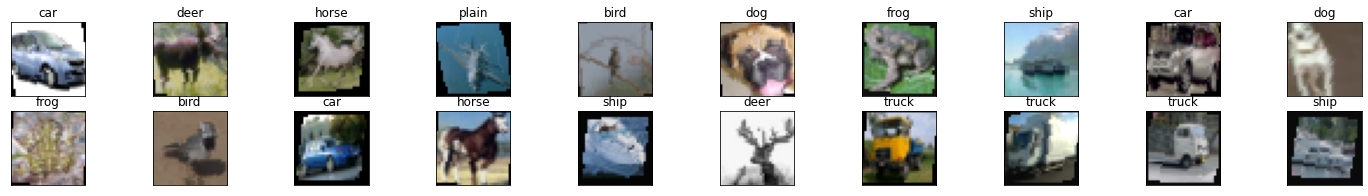

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 3))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])


In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # input: 1, depth: 20, kernel size: 5, stride length: 1
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4 * 4 * 64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2) # extract max feature of 2x2 size kernel
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64) # -1 option of view function automatically calculate the remaining dimention
    x = x.view(-1, 4*4*64) # -1 option of view function automatically calculate the remaining dimention
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

    
  else: # else section will be called after for loop
    with torch.no_grad(): # set all the grad flags to be false. It meams this block of codes doesn't affect grad.
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch: ', e+1)
    print('training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


epoch:  1
training loss: 1.6885, acc: 37.8920
validation loss: 1.3803, acc: 49.3000
epoch:  2
training loss: 1.3798, acc: 50.2040
validation loss: 1.2315, acc: 55.1900
epoch:  3
training loss: 1.2458, acc: 55.3140
validation loss: 1.1190, acc: 60.0600
epoch:  4
training loss: 1.1601, acc: 58.3700
validation loss: 1.0573, acc: 62.3600
epoch:  5
training loss: 1.0989, acc: 60.9240
validation loss: 0.9715, acc: 65.6300
epoch:  6
training loss: 1.0454, acc: 62.8820
validation loss: 0.9630, acc: 66.6200
epoch:  7
training loss: 1.0091, acc: 64.4700
validation loss: 0.9208, acc: 68.1900
epoch:  8
training loss: 0.9780, acc: 65.5540
validation loss: 0.9004, acc: 68.4100
epoch:  9
training loss: 0.9479, acc: 66.8000
validation loss: 0.8541, acc: 70.3800
epoch:  10
training loss: 0.9225, acc: 67.7480
validation loss: 0.8315, acc: 71.3400
epoch:  11
training loss: 0.9055, acc: 68.1900
validation loss: 0.8331, acc: 71.0900
epoch:  12
training loss: 0.8868, acc: 68.9800
validation loss: 0.8070, ac

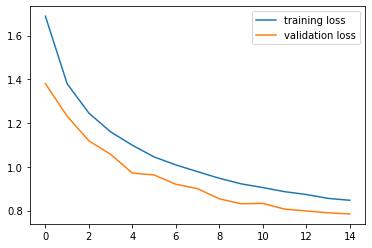

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

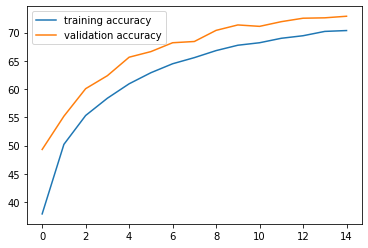

In [ ]:
running_corrects_history = torch.tensor(running_corrects_history, device = 'cpu')
val_running_corrects_history = torch.tensor(val_running_corrects_history, device = 'cpu')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
# !pip3 install pillow==4.0.0

<Response [200]>


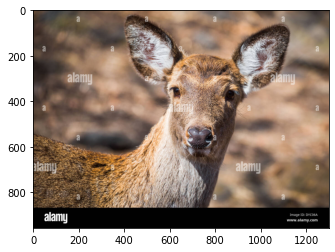

In [ ]:
import PIL.ImageOps
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
print(response)
img = Image.open(response.raw)
plt.imshow(img)

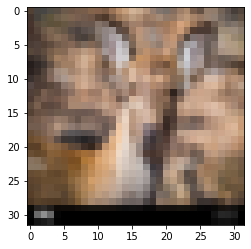

In [ ]:
img = transform(img) # resize and normalize
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


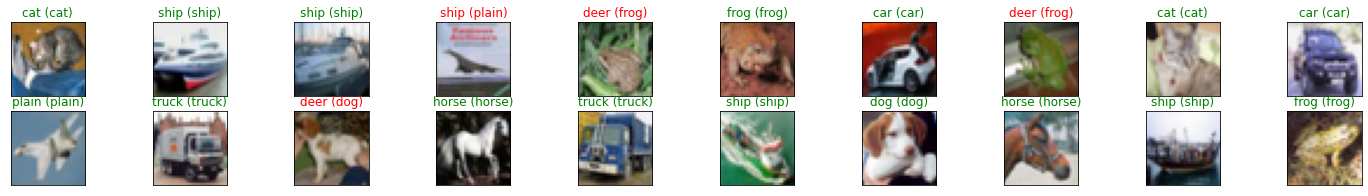

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 3))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title('{} ({})'.format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ('green' if preds[idx] == labels[idx] else 'red'))